# Objective to link speakers to newspapers to build a graph

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import math
import json
import bz2
import time
import sys
import csv

In [2]:
#top_n_Occurrences_quotes.to_csv('topOccurences/topOccurences2020domains.csv',sep=',',header=True)

## Try to get the newspaper name by removing https:// and the domain .com, .ch, etc.

In [3]:
def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()

In [293]:
n = 100
top_n_Occurrences_quotes2020 = pd.read_csv('topOccurences/topOccurences2020domains.csv',sep=",",nrows=n,header=0)
top_n_Occurrences_quotes2020.head()

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,7998,2020-01-08-103116,work to become financially independent.,Duchess of Sussex,['Q3304418'],2020-01-08 00:00:00,2037,"[['Duchess of Sussex', '0.5236'], ['Prince Har...",['http://kaaltv.com/news/prince-harry-meghan-s...,E
1,73203,2020-03-03-034586,it's just a straight arrow up of excitement,Mike Holmes,"['Q14950204', 'Q20676979', 'Q6847289', 'Q68472...",2020-03-03 00:00:00,1952,"[['Mike Holmes', '0.6468'], ['None', '0.3183']...",['http://www.gamereactor.eu/doom-eternal-its-j...,E
2,27459,2020-02-07-059825,make it impossible for me to do my job.,William Barr,"['Q16683338', 'Q43123958', 'Q43911234', 'Q8005...",2020-02-07 00:00:00,1105,"[['William Barr', '0.6779'], ['None', '0.1921'...",['http://www.canindia.com/trump-should-stop-tw...,E
3,85979,2020-02-04-034120,I naturally progressed to watching FIFA and th...,Gareth Bale,['Q184586'],2020-02-04 00:00:00,1101,"[['Gareth Bale', '0.8337'], ['None', '0.1663']]",['http://www.gamereactor.eu/esports/841413/Gar...,E
4,72467,2020-02-04-064050,"On the pitch, my goal is always to win. With E...",Gareth Bale,['Q184586'],2020-02-04 00:00:00,1101,"[['Gareth Bale', '0.8089'], ['None', '0.1911']]",['http://www.gamereactor.eu/esports/841413/Gar...,E


In [142]:
# Throw the whole URLS to this function
def shorten_url(urls):
    URLS_clean = [[]] * n
    
    # Loop around the top 10 quotes, cited by X newspapers (corresponds to X urls)
    for i in range(len(urls)):
    
        # New URLS list with the urls of one of the 10 top quotes
        URLS_splitted = []
        URLS_splitted.append(urls[i].split('http'))
        URLS = []
        
        # Loop in each of these newspapers which cited this quote
        for j in range(1+urls[i].count('http')):
            
            newsp_name = ''
            newsp_name1 = ''
            
            # Get split points where to keep to get the website name correctly
            if ("//www." in URLS_splitted[0][j]) == True:
                splitPoint1 = URLS_splitted[0][j].find("//www.")
                newsp_name1 = ''.join(URLS_splitted[0][j][splitPoint1+6:]) # Add 6 because of the length of "//www."
                        
            elif ("//" in URLS_splitted[0][j]) == True:
                splitPoint1 = URLS_splitted[0][j].find("//")
                newsp_name1 = ''.join(URLS_splitted[0][j][splitPoint1+2:]) # Add 2 because of the length of "//"
       
            if ("." in URLS_splitted[0][j]) == True:
                splitPoint2 = newsp_name1.find(".")
                newsp_name = ''.join(newsp_name1[:splitPoint2]) # Remove the . of .com
                
            if j > 0:
                URLS.append(newsp_name)
                
        URLS_clean[i].append(URLS)
    
         
        printProgressBar(i,len(urls)-1,"done")
    
    return URLS_clean

In [154]:
short_urls = shorten_url(top_n_Occurrences_quotes2020['urls'])

[==========] 100%  done

In [155]:
short_urls[0][0][0]

'kaaltv'

 ## Removing some outliers on quotes relayed by less than 3 newspapers

In [294]:
for i in range(top_n_Occurrences_quotes2020.shape[0]):
    
    if len(pd.DataFrame(short_urls).iloc[i].unique()) < 3:
        top_n_Occurrences_quotes2020 = top_n_Occurrences_quotes2020.drop(index=i)
top_n_Occurrences_quotes2020 = top_n_Occurrences_quotes2020.reset_index(drop=True)

In [295]:
top_n_Occurrences_quotes2020

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,7998,2020-01-08-103116,work to become financially independent.,Duchess of Sussex,['Q3304418'],2020-01-08 00:00:00,2037,"[['Duchess of Sussex', '0.5236'], ['Prince Har...",['http://kaaltv.com/news/prince-harry-meghan-s...,E
1,27459,2020-02-07-059825,make it impossible for me to do my job.,William Barr,"['Q16683338', 'Q43123958', 'Q43911234', 'Q8005...",2020-02-07 00:00:00,1105,"[['William Barr', '0.6779'], ['None', '0.1921'...",['http://www.canindia.com/trump-should-stop-tw...,E
2,71484,2020-01-26-042590,The Room Where It Happened: A White House memoir.,John Bolton,"['Q24676423', 'Q3079582', 'Q311269', 'Q5357886...",2020-01-26 00:00:00,974,"[['John Bolton', '0.4752'], ['None', '0.3689']...",['http://www.kob.com/news/democrats-demand-bol...,E
3,79450,2020-02-03-088018,today marks the beginning of the end for Donal...,Bernie Sanders,['Q359442'],2020-02-03 00:00:00,954,"[['Bernie Sanders', '0.7393'], ['None', '0.114...",['http://www.fox10phoenix.com/news/bad-start-f...,E
4,65609,2020-01-26-016934,I NEVER told John Bolton that the aid to Ukrai...,President Donald Trump,['Q22686'],2020-01-26 00:00:00,922,"[['President Donald Trump', '0.5378'], ['None'...",['http://hppr.org/post/democrats-renew-demand-...,E
...,...,...,...,...,...,...,...,...,...,...
88,77958,2020-01-09-040959,I'll send them over when I'm ready -- and that...,Nancy Pelosi,['Q170581'],2020-01-09 11:09:37,574,"[['Nancy Pelosi', '0.5323'], ['None', '0.446']...",['http://p.washingtontimes.com/news/2020/jan/9...,E
89,95607,2020-02-09-058891,"Yes, you could call it that for sure.",Mary Lou McDonald,['Q467414'],2020-02-09 17:11:31,574,"[['Mary Lou McDonald', '0.7684'], ['None', '0....",['http://andoveradvertiser.co.uk/news/national...,E
90,39300,2020-02-14-068308,Particular attention will be paid to understan...,Tedros Adhanom Ghebreyesus,['Q16196017'],2020-02-14 00:00:00,572,"[['Tedros Adhanom Ghebreyesus', '0.7331'], ['N...",['http://hawaiipublicradio.org/post/more-1700-...,E
91,59457,2020-01-26-020166,If a president does something which he believe...,Alan Dershowitz,['Q183058'],2020-01-26 09:00:00,566,"[['Alan Dershowitz', '0.6317'], ['None', '0.27...",['https://www.brainerddispatch.com/news/nation...,E


## Get all quotations of a given subject, to do the sentiment analysis and clusters the quotes

In [10]:
n = 1e6
top_1M_Occurrences_quotes2020 = pd.read_csv('topOccurences/topOccurences2020domains.csv',sep=",",nrows=n,header=0)
top_1M_Occurrences_quotes2020.head()

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,7998,2020-01-08-103116,work to become financially independent.,Duchess of Sussex,['Q3304418'],2020-01-08 00:00:00,2037,"[['Duchess of Sussex', '0.5236'], ['Prince Har...",['http://kaaltv.com/news/prince-harry-meghan-s...,E
1,73203,2020-03-03-034586,it's just a straight arrow up of excitement,Mike Holmes,"['Q14950204', 'Q20676979', 'Q6847289', 'Q68472...",2020-03-03 00:00:00,1952,"[['Mike Holmes', '0.6468'], ['None', '0.3183']...",['http://www.gamereactor.eu/doom-eternal-its-j...,E
2,27459,2020-02-07-059825,make it impossible for me to do my job.,William Barr,"['Q16683338', 'Q43123958', 'Q43911234', 'Q8005...",2020-02-07 00:00:00,1105,"[['William Barr', '0.6779'], ['None', '0.1921'...",['http://www.canindia.com/trump-should-stop-tw...,E
3,85979,2020-02-04-034120,I naturally progressed to watching FIFA and th...,Gareth Bale,['Q184586'],2020-02-04 00:00:00,1101,"[['Gareth Bale', '0.8337'], ['None', '0.1663']]",['http://www.gamereactor.eu/esports/841413/Gar...,E
4,72467,2020-02-04-064050,"On the pitch, my goal is always to win. With E...",Gareth Bale,['Q184586'],2020-02-04 00:00:00,1101,"[['Gareth Bale', '0.8089'], ['None', '0.1911']]",['http://www.gamereactor.eu/esports/841413/Gar...,E


In [11]:
gun_quotes2020 = []

for i in range(top_1M_Occurrences_quotes2020.shape[0]):
    if pd.Series(top_1M_Occurrences_quotes2020.quotation[i]).str.contains('gun').bool() == True:
        gun_quotes2020.append(top_1M_Occurrences_quotes2020.quotation[i])

In [12]:
gun_quotes2020[:10]

['It appears the virus was acquired in the UK and full contact tracing has begun.',
 'I have always said a number of individuals were involved with the gunman on the night Lyra was killed and, while today is significant for the investigation, the quest for the evidence to bring the gunman to justice remains active and ongoing.',
 "I definitely didn't hear any gunshots. A lot of people messaged me saying there's gunshots but I didn't hear any.",
 'Whether kicking or screaming, end of US malign presence in West Asia has begun,',
 'Turkey has begun to heal the wounds of this great disaster in unity, togetherness and coming together.',
 'There were a lot of gunshots that started going off -- maybe 10 or 11. It was just rapid fire.',
 'Oh, oops, it looks like I accidentally made a machine gun.',
 "During the course of the investigation, we learned that the shooter posted a message on social media on Sept. 11 of last year that said: `the countdown has begun.' Over Thanksgiving weekend, he vi

In [13]:
len(gun_quotes2020)

234

In [14]:
climate_quotes2020 = []

for i in range(top_1M_Occurrences_quotes2020.shape[0]):
    if pd.Series(top_1M_Occurrences_quotes2020.quotation[i]).str.contains('climate').bool() == True:
        climate_quotes2020.append(top_1M_Occurrences_quotes2020.quotation[i])

In [15]:
climate_quotes2020[:10]

['I want to work alongside others both to amplify known ways and to explore new ways of fighting the devastating impact of climate change.',
 'Make no mistake. The tragedy unfolding in Australia is climate change-based.',
 "We'll never be able to protect every single household, just because of the nature of climate change and the fact that these weather events are becoming more extreme, but we've done everything that we can do with a significant sum of money, and there's more to come,",
 'has worked hard to make politicians open their eyes to the climate crisis.',
 'In our current climate of uncertainty, we believe the smartest approach is to take additional time to monitor how this situation unfolds, so we can best position our party for a safe and successful convention,',
 "It wouldn't be sustainable for very long but I still think it's worth exploring if we could do something to urgently address the housing crisis, some of the problems in the health service with the desperate waitin

In [16]:
len(climate_quotes2020)

334

## Getting URLS from the X-th most relayed quote by doing short_urls[0][X-1]

In [274]:
n = 100
top_n_Occurrences_quotes2020 = pd.read_csv('topOccurences/topOccurences2020domains.csv',sep=",",nrows=n,header=0)
top_n_Occurrences_quotes2020.head()## Getting URLS from the X-th most relayed quote by doing short_urls[0][X-1]
short_urls = pd.DataFrame(short_urls)

### The quote:

In [169]:
top_n_Occurrences_quotes2020.quotation[0]

'work to become financially independent.'

### has been said by:

In [170]:
top_n_Occurrences_quotes2020.probas[0]

"[['Duchess of Sussex', '0.5236'], ['Prince Harry', '0.2764'], ['None', '0.1806'], ['Queen Elizabeth II', '0.0111'], ['Prince Charles', '0.0018'], ['Prince Andrew', '0.0014'], ['Prince William', '0.0013'], ['Hugh Grant', '8.0E-4'], ['Harvey Levin', '5.0E-4'], ['Tom Bradby', '3.0E-4'], ['Rosie Gray', '3.0E-4'], ['Will Fuller', '3.0E-4'], ['Christopher Lee', '2.0E-4'], ['Amy Schumer', '2.0E-4'], ['Sarah Ferguson', '2.0E-4'], ['David Jones', '1.0E-4'], ['Piers Morgan', '1.0E-4'], ['Tracy Brown', '1.0E-4'], ['Buck Henry', '1.0E-4'], ['President Donald Trump', '1.0E-4'], ['Babar Azam', '1.0E-4'], ['Bianca Nobilo', '1.0E-4'], ['KATE MIDDLETON', '1.0E-4'], ['Kate Williams', '1.0E-4']]"

In [171]:
top_n_Occurrences_quotes2020

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,7998,2020-01-08-103116,work to become financially independent.,Duchess of Sussex,['Q3304418'],2020-01-08 00:00:00,2037,"[['Duchess of Sussex', '0.5236'], ['Prince Har...",['http://kaaltv.com/news/prince-harry-meghan-s...,E
1,73203,2020-03-03-034586,it's just a straight arrow up of excitement,Mike Holmes,"['Q14950204', 'Q20676979', 'Q6847289', 'Q68472...",2020-03-03 00:00:00,1952,"[['Mike Holmes', '0.6468'], ['None', '0.3183']...",['http://www.gamereactor.eu/doom-eternal-its-j...,E
2,27459,2020-02-07-059825,make it impossible for me to do my job.,William Barr,"['Q16683338', 'Q43123958', 'Q43911234', 'Q8005...",2020-02-07 00:00:00,1105,"[['William Barr', '0.6779'], ['None', '0.1921'...",['http://www.canindia.com/trump-should-stop-tw...,E
3,85979,2020-02-04-034120,I naturally progressed to watching FIFA and th...,Gareth Bale,['Q184586'],2020-02-04 00:00:00,1101,"[['Gareth Bale', '0.8337'], ['None', '0.1663']]",['http://www.gamereactor.eu/esports/841413/Gar...,E
4,72467,2020-02-04-064050,"On the pitch, my goal is always to win. With E...",Gareth Bale,['Q184586'],2020-02-04 00:00:00,1101,"[['Gareth Bale', '0.8089'], ['None', '0.1911']]",['http://www.gamereactor.eu/esports/841413/Gar...,E
...,...,...,...,...,...,...,...,...,...,...
95,77958,2020-01-09-040959,I'll send them over when I'm ready -- and that...,Nancy Pelosi,['Q170581'],2020-01-09 11:09:37,574,"[['Nancy Pelosi', '0.5323'], ['None', '0.446']...",['http://p.washingtontimes.com/news/2020/jan/9...,E
96,95607,2020-02-09-058891,"Yes, you could call it that for sure.",Mary Lou McDonald,['Q467414'],2020-02-09 17:11:31,574,"[['Mary Lou McDonald', '0.7684'], ['None', '0....",['http://andoveradvertiser.co.uk/news/national...,E
97,39300,2020-02-14-068308,Particular attention will be paid to understan...,Tedros Adhanom Ghebreyesus,['Q16196017'],2020-02-14 00:00:00,572,"[['Tedros Adhanom Ghebreyesus', '0.7331'], ['N...",['http://hawaiipublicradio.org/post/more-1700-...,E
98,59457,2020-01-26-020166,If a president does something which he believe...,Alan Dershowitz,['Q183058'],2020-01-26 09:00:00,566,"[['Alan Dershowitz', '0.6317'], ['None', '0.27...",['https://www.brainerddispatch.com/news/nation...,E


### And were relayed by:

In [172]:
short_urls.iloc[0][:10]

0               kaaltv
1                 wdio
2               toofab
3               KAALtv
4                 whec
5           uspolitics
6        harpersbazaar
7         seattletimes
8    alaskahighwaynews
9    alaskahighwaynews
Name: 0, dtype: object

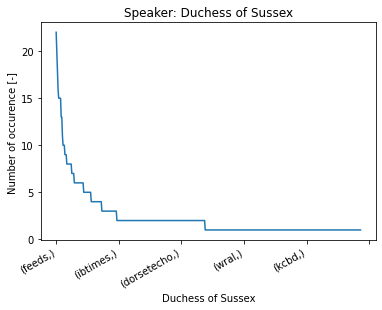

In [173]:
df = pd.DataFrame({top_n_Occurrences_quotes2020.speaker[0]:pd.Series(short_urls.iloc[0]).str.lower().reset_index(drop = True)})
df_line1_counted = df.value_counts()
df_line1_counted.plot(ylabel  = "Number of occurence [-] "),plt.xticks(rotation=30, ha='right'),plt.title("Speaker: " + df.loc[0].index[0])
plt.draw()

# Distribution of the number of newspaper in the 100 most relayed quotes

In [174]:
short_urls = shorten_url(top_n_Occurrences_quotes2020['urls'])
short_urls = short_urls[0]
short_urls = pd.DataFrame(short_urls)

[==========] 100%  done

In [175]:
list_of_np = pd.DataFrame(columns = ['newspaper'])
for index in short_urls.T:
    list_of_np = pd.concat([list_of_np, pd.DataFrame({'newspaper' : short_urls.T[index].dropna()})], ignore_index=True)

In [176]:
list_of_unique_np = list_of_np.drop_duplicates()
count_np = pd.DataFrame(columns=['journal', 'nb_occurence'])

for journal in list_of_unique_np['newspaper']:
    new_journal = pd.DataFrame({'journal' : journal, 'nb_occurence' : [len(list_of_np[list_of_np['newspaper']==journal])]})
    count_np = count_np.append(new_journal)

In [177]:
count_np = count_np.sort_values('nb_occurence',ascending=False)
count_np

,journal,nb_occurence
0,news965,7825
0,wral,6728
0,gamereactor,6506
0,wsbradio,4189
0,wokv,1712
...,...,...
0,arstechnica,1
0,thetrumpet,1
0,storypick,1
0,bainbridgereview,1


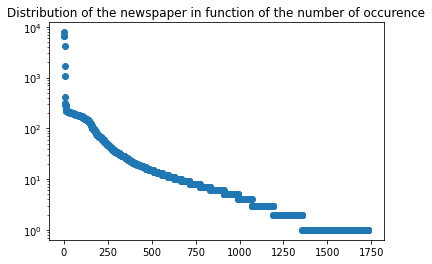

In [178]:
plt.scatter(range(len(count_np.nb_occurence)),count_np.nb_occurence)
plt.title("Distribution of the newspaper in function of the number of occurence")

plt.yscale('log')
plt.draw()

In [179]:
df.dropna().drop_duplicates().reset_index(drop = True)

,Duchess of Sussex
0,kaaltv
1,wdio
2,toofab
3,whec
4,uspolitics
...,...
482,nst
483,tv360nigeria
484,pakistantoday
485,rappler


# Can we do cool graph to link speaker and newspapers that quoted them ? 

In [180]:
#We will try to do a simple graph to start with using the first quotation

list_of_NP = df.dropna().drop_duplicates().reset_index(drop = True)
Speaker = "Duchess of Sussex"
df_line1 = df[df.index == 'Duchess of Sussex'].T
G = nx.MultiGraph()
G.add_node(Speaker)
G.add_nodes_from(list_of_NP)
color_map = []
color_map.append('red')  

for i in range(0,len(list_of_NP),1):
    G.add_edge(Speaker,list_of_NP.iloc[i][0])
    color_map.append('blue')     

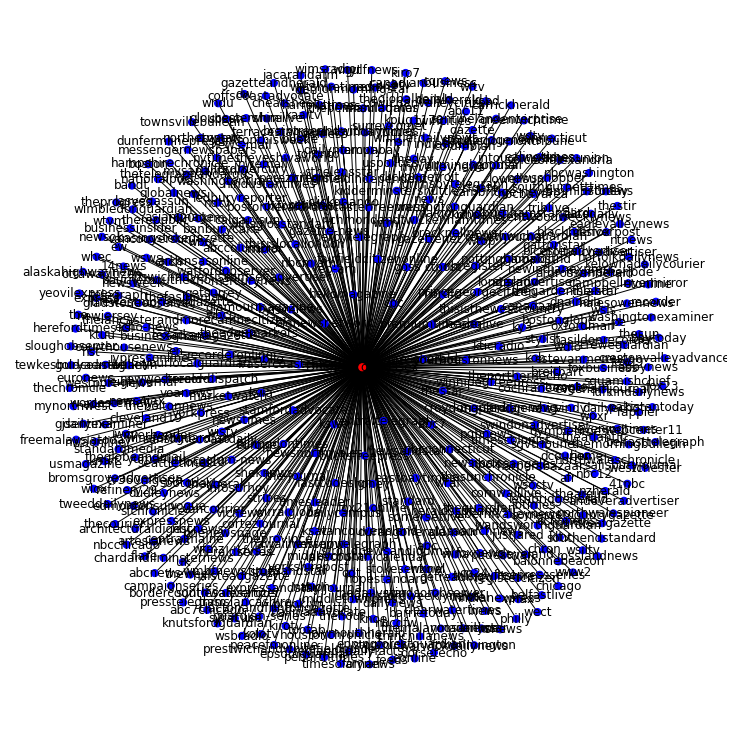

In [181]:
plt.figure(figsize=(10,10))
nx.draw(G, node_color=color_map, with_labels = True, node_size = 50, alpha = 1)

In [ ]:
for i in range(top_n_Occurrences_quotes2020.shape[0]):
    
    if len(pd.DataFrame(short_urls).iloc[i].unique()) < 3:
        top_n_Occurrences_quotes2020 = top_n_Occurrences_quotes2020.drop(index=i)
top_n_Occurrences_quotes2020 = top_n_Occurrences_quotes2020.reset_index(drop=True)

In [296]:
#Trying to expand the graph to all lines of df without any selection of the np

G = nx.MultiGraph()
#df_index = df.index
#df_index = df_index.drop_duplicates()
df_index = top_n_Occurrences_quotes2020.speaker.drop_duplicates()

for speaker in df_index:
    df_speaker = short_urls[short_urls.index == speaker]

    if len(df_speaker) != 1:
        df_speaker = pd.DataFrame(df_speaker.iloc[:,0])    
    list_of_NP = df_speaker.iloc[0].str.lower().drop_duplicates().dropna().reset_index(drop=True)
    
    G.add_node(speaker)
    G.add_nodes_from(list_of_NP) # note add_note will not create 2 nodes with the same name 

    for NP in list_of_NP:
        G.add_edge(speaker,NP)
        
color_map = ['blue']*len(G.nodes)
color_map[:len(df_index)] = ['red']*len(df_index)

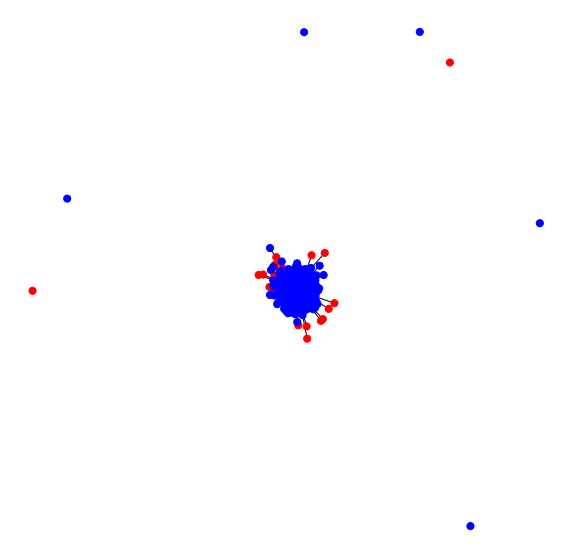

In [300]:
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.circular_layout(G)

nx.draw(G, with_labels = False, node_color=color_map, node_size = 50, alpha = 1, ax=ax)

In [304]:
# Trying to expand the graph to all lines of df
G = nx.MultiGraph()
count_np_red = count_np[count_np.nb_occurence > 300] # using only np with more than 10 occurences 

# list of speaker 
df_index = top_n_Occurrences_quotes2020.speaker.drop_duplicates()

G.add_nodes_from(df_index)

for speaker in df_index:
    df_speaker = short_urls[short_urls.index == speaker]
    
    if len(df_speaker) != 1:
        df_speaker = pd.DataFrame(df_speaker.iloc[:,0])    
        
    list_of_NP = df_speaker.iloc[0].str.lower().drop_duplicates().dropna().reset_index(drop=True)
    G.add_nodes_from(count_np_red.journal) # NB: add_note will not create 2 nodes with the same name 
    
    for NP in list_of_NP:
        if len(count_np_red[count_np_red.journal == NP].journal) > 0:
            G.add_edge(speaker,NP)            
            
           
color_map = ['blue']*len(G.nodes)
color_map[:len(df_index)] = ['red']*len(df_index)

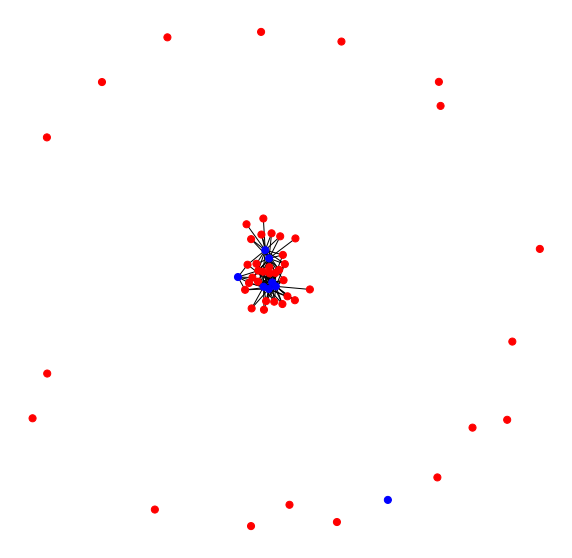

In [305]:
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.circular_layout(G)

nx.draw(G, with_labels = False, node_size = 50,node_color=color_map, alpha = 1,ax=ax)

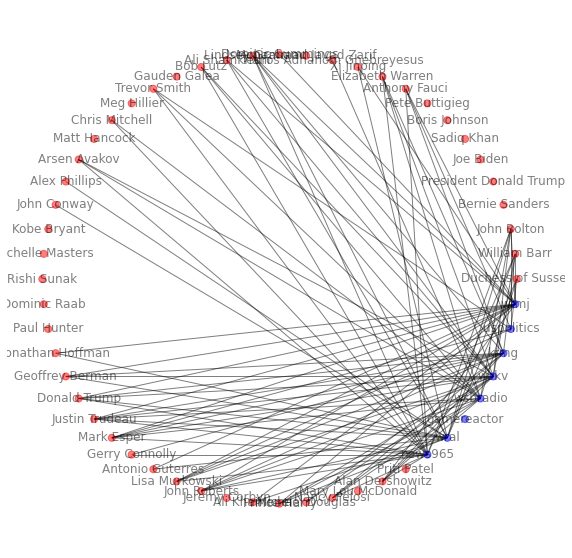

In [306]:
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.circular_layout(G)

nx.draw(G, pos,with_labels = True, ax=ax , node_color=color_map, node_size = 50, alpha = .5)